## Loading initial excel file

In [1]:
from textwrap import shorten

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from faker import Faker
from scipy.spatial.distance import cdist
from sentence_transformers import SentenceTransformer, util
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

import fetch
from fetch.utils import json_or_fetch
import modules.urls as urls

In [2]:
df = pd.read_excel('data/SOFT-3.xlsx', header=1)
df = df.drop(df.columns[0], axis=1)
# df.head()

## Anonymising the data (student names)

In [3]:
faker = Faker()
dict_names = {name: faker.name() for name in df['student'].unique()}
df['student'] = df['student'].map(dict_names)
df.head()

,student,company
0,Edward Caldwell,Dynatest A/S
1,Karen Lawson,"Eriksholm Research Centre, Oticon"
2,Brian Kim,Formpipe
3,Nicole Swanson,Formpipe
4,Dan Tucker,Formpipe


## Getting company data with CVR API

In [4]:
df['company'].unique().size

25

These are the older deprecated cells that fetched and stored JSON data about the companies. There's a refactored version meant to be more reusable in `fetch/utils.py`.

In [5]:
# import json
# from os.path import exists

# # init empty dict
# dict_company_data = {}
# # loads from json file if exists
# path = 'data/company_data.json'
# if exists(path):
#     with open(path) as f:
#         dict_company_data = json.load(f)

In [6]:
# # if company from df is not in the existing json file, we get info from API
# for company in df['company'].unique():
#     if company not in dict_company_data.keys():
#         dict_company_data[company] = get_company_data(company)

# # overwrite existing json file with fresh data
# with open(path, 'w') as f:
#     json.dump(dict_company_data, f)

In [7]:
dict_company_data = json_or_fetch(df['company'].unique(), fetch.cvrapi, 'data/company_data.json')

In [8]:
df_company = pd.DataFrame.from_dict(dict_company_data, orient='index')
df_company.head()

,vat,name,address,zipcode,city,cityname,protected,phone,email,fax,...,industrydesc,companycode,companydesc,creditstartdate,creditbankrupt,creditstatus,owners,productionunits,t,version
Dynatest A/S,20318872,A/S DYNATEST ENGINEERING,Generatorvej 21,2730,Herlev,None,False,NaN,None,NaN,...,Uoplyst,60,Aktieselskab,12/03 - 2001,True,1.0,None,"[{'pno': 1004239898, 'main': True, 'name': 'A/...",100,6
"Eriksholm Research Centre, Oticon",50091015,PROPOLIS RESEARCH CENTRE A/S,Lille Veksøvej 11,3670,Veksø Sjælland,None,False,NaN,None,NaN,...,"Andre liberale, videnskabelige og tekniske tje...",60,Aktieselskab,None,False,NaN,None,"[{'pno': 1001942680, 'main': True, 'name': 'PR...",100,6
Formpipe,26366216,FORMPIPE LASERNET A/S,Lautrupvang 1,2750,Ballerup,None,False,43660210.0,admin.lasernet@formpipe.com,NaN,...,Anden udgivelse af software,60,Aktieselskab,None,False,NaN,[{'name': 'Formpipe Software AB'}],"[{'pno': 1008829868, 'main': True, 'name': 'FO...",100,6
Novo Nordisk,24256790,NOVO NORDISK A/S,Novo Alle 1,2880,Bagsværd,None,False,44448888.0,None,NaN,...,Fremstilling af farmaceutiske præparater,60,Aktieselskab,None,False,NaN,None,"[{'pno': 1017661031, 'main': False, 'name': 'N...",100,6
PFA,31050162,PFA BANK A/S,Sundkrogsgade 4,2100,København Ø,None,False,70808500.0,post@pfabank.dk,39172950.0,...,"Banker, sparekasser og andelskasser",60,Aktieselskab,None,False,NaN,None,"[{'pno': 1013750293, 'main': True, 'name': 'PF...",100,6


## Get more data from Proff
Because we don't have access to the API, and there's no way that I can see of deducing the URL to the company page, I will just make a `list` of URLs to scrape, one for each company. The annoying part is having to update this when new companies are added. Same goes for the URLs below when we do text vectorisation.

If we had the most accurate CVR number in our starting data, we could search on that programmatically, and pick the top result. As it is, we could do that, but if CVR API gave us the wrong company based on only the name, we won't get the most accurate data.

**Actually!** You can use the URL pattern `https://proff.dk/firma/-/-/-/CVR`. It'll redirect to the real page. The `-` (dashes) are also optional, but whenever Proff themselves shorten the links, they put those in as placeholders. This way we can get the links completely programatically more easily.

Another problem is what to do with companies you do not have their finances publically available on Proff. They should be all NaN, then. It'll either error when you try to get a table from the empty site, or if you try to find the link from the main which doesn't exist (no `<a>` tag). So how you error handle might change over time.

In [9]:
proff_data = json_or_fetch(urls.proff, fetch.proff, 'data/proff_data.json')

Now that we have the data from Proff, we can add it to our dataframe.

In [10]:
# from_dict has a messed up row order, so we transpose it
df_proff = pd.DataFrame(proff_data).T
df_proff.set_index(df_company.index, inplace=True)
df_proff

,2022,2021,2020,employees,2019,2018,2017,2016,2015,2014,2013
Dynatest A/S,3581.0,9606.0,4530.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Eriksholm Research Centre, Oticon",NaN,1525319.0,165416.0,42.0,551594.0,962573.0,1011568.0,743559.0,730954.0,535275.0,798601.0
Formpipe,NaN,36583.0,14719.0,87.0,7525.0,10511.0,-748.0,-4924.0,-4145.0,-590.0,-7751.0
Novo Nordisk,NaN,47523000.0,42159000.0,22150.0,39252000.0,38530000.0,37873000.0,37791000.0,34623000.0,26413000.0,25190000.0
PFA,-511000.0,-79000.0,108000.0,1464.0,10000.0,92000.0,181000.0,136000.0,-587000.0,548000.0,224000.0
Topdanmark,NaN,2138000.0,NaN,8.0,1547000.0,1331000.0,1733000.0,1536000.0,1132000.0,1558000.0,1468000.0
KMD A/S,53926.0,2893.0,173758.0,1855.0,-238596.0,NaN,177700.0,244400.0,500600.0,81800.0,53100.0
NorthTech ApS,NaN,5.0,598.0,20.0,792.0,1124.0,1010.0,1497.0,1931.0,672.0,362.0
Alpha Solutions,3477.0,4334.0,-2940.0,59.0,-3279.0,4171.0,3385.0,2243.0,5079.0,3439.0,2500.0
Dafolo,36271.0,1339.0,40.0,83.0,3162.0,-489.0,-5862.0,-2121.0,1439.0,4170.0,844.0


The column order is slightly messed up because employees is encountered before the rest of the years, so we could move it to the front with `pop` and `insert`.

```python
df_proff.insert(0, 'employees', df_proff.pop('employees'))
```

However, we actually want to just replace the original column.

In [11]:
df_company['employees'] = df_proff.pop('employees')

In [12]:
# cast columns names (years) to int
# annoyingly, when we read these headers from csv, they are read as strings anyway.
# and then it's much harder to locate them to cast them.
# so it might be better to not cast it here, and just cast it when we need it.
df_proff.columns = df_proff.columns.astype(int)

In [13]:
df_company = pd.concat([df_company, df_proff], axis=1)

## Cleaning the company DataFrame

In [14]:
# Amount of non-nan values per column.
df_company.count()

vat                25
name               25
address            25
zipcode            25
city               25
cityname            1
protected          25
phone              16
email              14
fax                 5
startdate          25
enddate             1
employees          23
addressco           4
industrycode       25
industrydesc       25
companycode        25
companydesc        25
creditstartdate     1
creditbankrupt     25
creditstatus        1
owners              4
productionunits    25
t                  25
version            25
2022                8
2021               23
2020               21
2019               20
2018               19
2017               18
2016               17
2015               17
2014               17
2013               16
dtype: int64

In [15]:
# specifically the missing values of the financial data
df_company.loc[:,2022:].isna().sum()

2022    17
2021     2
2020     4
2019     5
2018     6
2017     7
2016     8
2015     8
2014     8
2013     9
dtype: int64

In [16]:
df_company.drop(2022, axis=1, inplace=True)

In [17]:
no_rows = df_company.shape[0]
df_company.dropna(axis=1, thresh=no_rows * 0.1, inplace=True)   # drops columns with 90 % missing data

In [18]:
def all_same(series):
    return (series == series[0]).all()

cols_with_same_vals = [col for col in df_company.columns if col != 'productionunits' and all_same(df_company[col])]
print(cols_with_same_vals)
df_company.drop(cols_with_same_vals, axis=1, inplace=True)

['t', 'version']


In [19]:
# drop various columns I don't want
df_company.drop(['protected', 'fax', 'companycode', 'companydesc', 'owners'], axis=1, inplace=True)

In [20]:
# removes floor of addresses to format for geo coordinates search.
df_company['address'] = df_company['address'].apply(lambda a: a.split(',')[0])

In [21]:
df_company.to_csv('data/cleaned_data.csv')

## Geolocation data

In [22]:
geo_data = json_or_fetch(df_company['address'], fetch.geolocation, 'data/geo_data.json')

In [23]:
# unzips the coordinate tuples
lats, lons = zip(*geo_data.values())
df_company['latitude'] = lats
df_company['longitude'] = lons

In [24]:
df_company.to_csv('data/cleaned_data.csv')

In [25]:
first_coords = df_company.iloc[0][['latitude', 'longitude']]
m = folium.Map(location=first_coords, zoom_start=12)
for idx, row in df_company.iterrows():
    folium.Marker(row[['latitude', 'longitude']], popup=f"<b>{row['name']}</b> <i>{row['industrydesc']}</i>").add_to(m)
m.save('renders/map.html')
m

### Location clustering

In [26]:
coordinates = df_company[['latitude', 'longitude']]
coordinates

,latitude,longitude
Dynatest A/S,55.729930,12.464800
"Eriksholm Research Centre, Oticon",55.757949,12.228728
Formpipe,55.733204,12.391164
Novo Nordisk,55.754555,12.455185
PFA,55.708655,12.591288
Topdanmark,55.734142,12.380579
KMD A/S,55.736130,12.393105
NorthTech ApS,55.674321,12.591612
Alpha Solutions,55.682038,12.583964
Dafolo,57.445530,10.493744


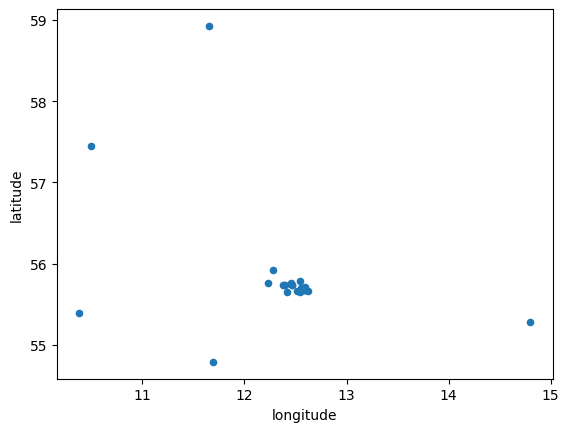

In [27]:
coordinates.plot.scatter(x='longitude', y='latitude')
plt.show()

#### K-Means

In [28]:
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(coordinates)
    # calculate distortion and append to list
    distortions.append(sum(np.min(cdist(coordinates, kmeans.cluster_centers_, 'euclidean'), axis=1)) / coordinates.shape[0])
print(distortions)

[0.6267281104776248, 0.40489858010952057, 0.3410088889446933, 0.21761471661468135, 0.14238771120123406, 0.08481657325305729, 0.0455992033243183, 0.035291375896829076, 0.0282859692089631]


In [29]:
def plot_distortion_elbow():
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

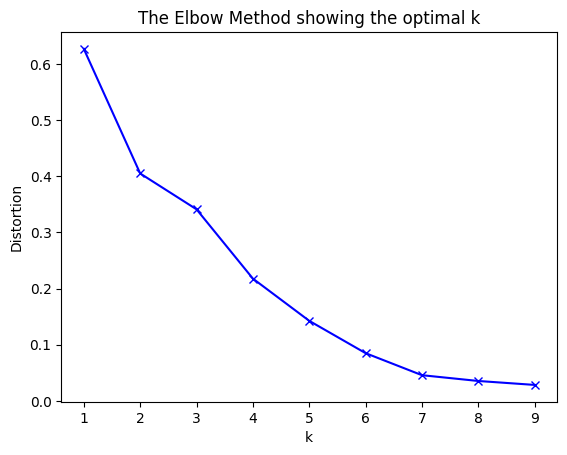

In [30]:
plot_distortion_elbow()

In [31]:
scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(coordinates)
    # default metric for silhouette is euclidean
    scores.append(metrics.silhouette_score(coordinates, kmeans.labels_, sample_size=coordinates.shape[0]))
print(scores)

[0.7801497538704936, 0.7650828753193405, 0.7502275268005083, 0.7351928761714559, 0.7036386647187787, 0.4365649822576133, 0.4586726452294321, 0.4363252934937482]


In [32]:
num_clusters = 4

In [33]:
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=20)
kmeans.fit(coordinates)

KMeans(n_clusters=4, n_init=20)

In [34]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 3, 0, 2, 1,
       2, 2, 2])

In [35]:
kmeans.cluster_centers_

array([[55.0921295 , 11.036604  ],
       [58.18649555, 11.07271185],
       [55.716732  , 12.488028  ],
       [55.274825  , 14.800772  ]])

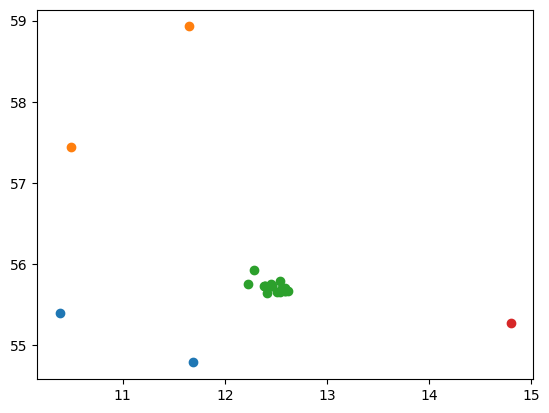

In [36]:
for i in range(num_clusters):
    cluster = coordinates[kmeans.labels_ == i]
    plt.scatter(cluster['longitude'], cluster['latitude'], label=f'Cluster {i}')

If you want to plot the clusters separately, then you should consider supplying the min and max values to the plot, so that they are mapped unto the same position as they would be in the plot with all of them.

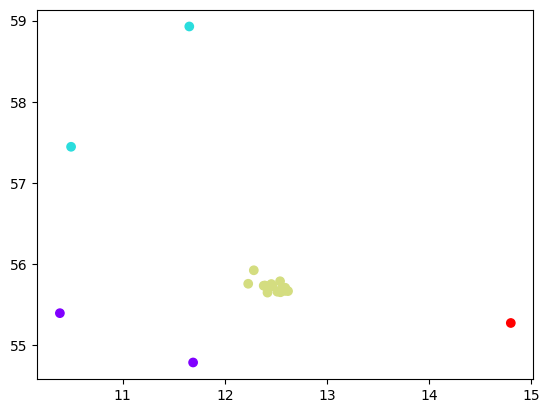

In [37]:
# Another way to plot them all at once
plt.scatter(coordinates['longitude'], coordinates['latitude'], c=kmeans.labels_, cmap='rainbow')
# different cmap are colour schemes. See https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# 'viridis' is a good one too

And now with the boundaries of the clusters.

In [38]:
x_min, x_max = coordinates['longitude'].min(), coordinates['longitude'].max()
y_min, y_max = coordinates['latitude'].min(), coordinates['latitude'].max()

In [39]:
# we need a grid of points for drawing a smooth border between clusters
# define step size of the mesh 
step_size = 0.01

# we need to cover all points of our data
# create a grid out of an array of X values and an array of y values
x_coord = np.arange(x_min, x_max, step_size)
y_coord = np.arange(y_min, y_max, step_size)

# meshgrid() creates a matrix of coordinates from the two vectors of coordinates
x_vals, y_vals = np.meshgrid(x_coord, y_coord)

In [40]:
# Predict cluster labels for all the points on the grid 
# ravel() returns 1D-array
xx = x_vals.ravel()
yy = y_vals.ravel()

# np.c_ concatenates the arguments
labels = kmeans.predict(np.c_[xx,yy])
labels = labels.reshape(x_vals.shape)

c:\Python39\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


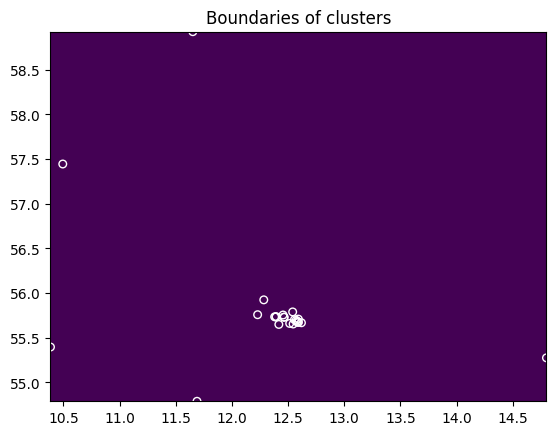

In [41]:
# Plot the clusters
# create new plot area
plt.figure()
# clear the plot area
plt.clf()

plt.title('Boundaries of clusters')

# plot the frame
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# plot the clusters 
plt.imshow(labels, interpolation='nearest',
           extent=(x_vals.min(), x_vals.max(), y_vals.min(), y_vals.max()),
           cmap='viridis', aspect='auto')
# plot the points as they belong to the clusters
plt.scatter(coordinates['longitude'], coordinates['latitude'], marker='o', facecolors='none', edgecolors='white', s=30) 

# plot the centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1],  s=200, linewidths=2, color='yellow', marker='*', zorder=3, facecolors='black')

# annotate the centroids
for i, center in enumerate(centers):
    plt.annotate(i, center+[0.0,1.0], 
                 size=15, zorder=1, color='yellow', weight='bold', 
                 horizontalalignment='center', verticalalignment='center',) 
plt.show()

With some clusters only having one node, it looks ugly as hell, because those don't seem to show.

Even with 4 clusters to some are grouped together, it looks extremely messed up.

## Text Vectorisation

In [42]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [43]:
corpus_embeddings = embedder.encode(df_company['industrydesc'])

### Which two companies are closest?

In [44]:
idx1 = 0
idx2 = 0
score = 0

for i, query_embedding in enumerate(corpus_embeddings):
    for j, corpus_embedding in enumerate(corpus_embeddings):
        sim = util.cos_sim(query_embedding, corpus_embedding)
        val = sim.tolist()[0][0]
        # if new max similarity and not matching self
        if score < val and i != j:
            idx1 = i
            idx2 = j
            score = val

print(idx1, idx2, score)
print(df_company.iloc[[idx1, idx2]][['name', 'industrydesc']])

6 8 1.0
                                name  \
KMD A/S                      KMD A/S   
Alpha Solutions  ALPHA SOLUTIONS A/S   

                                                      industrydesc  
KMD A/S          Konsulentbistand vedrørende informationsteknologi  
Alpha Solutions  Konsulentbistand vedrørende informationsteknologi  


### Scraping

In [45]:
df_company.index

Index(['Dynatest A/S', 'Eriksholm Research Centre, Oticon', 'Formpipe',
       'Novo Nordisk', 'PFA', 'Topdanmark', 'KMD A/S', 'NorthTech ApS',
       'Alpha Solutions', 'Dafolo', 'Nuuday A/S', 'Netcompany A/S',
       'Wash World', 'Carve', 'GroupM', 'Brøndbyernes I.F.', 'Meew', 'Funelo',
       'PreCure', 'Wilke', 'OOONO', 'Elbek & Vejrup', 'Ellab', 'Lejka',
       'Firi'],
      dtype='object')

In [46]:
texts = json_or_fetch(urls.websites, fetch.scrapetext, 'data/website_text.json')
texts = {k: ' '.join(v) for k, v in texts.items()}
# joins list of paragraphs for each website because I think that's what I actually need.

In [47]:
corpus_embeddings = embedder.encode(list(texts.values()))

### Querying

In [48]:
queries = ['Software','development', 'udvikling', 'programmering', 'programming']
query_embedding = embedder.encode(queries)

In [49]:
for idx, embedding in enumerate(corpus_embeddings):
    sim = util.cos_sim(query_embedding, embedding)
    print("{}:\t\t{:.4f}".format(df_company.iloc[idx]['name'], sim.tolist()[0][0]))

A/S DYNATEST ENGINEERING:		0.1169
PROPOLIS RESEARCH CENTRE A/S:		0.1714
FORMPIPE LASERNET A/S:		0.1248
NOVO NORDISK A/S:		0.1259
PFA BANK A/S:		-0.0880
TOPDANMARK A/S:		0.1361
KMD A/S:		0.1953
NORTHTECH ApS:		0.2179
ALPHA SOLUTIONS A/S:		0.2515
DAFOLO A/S:		0.1993
Nuuday A/S:		0.1135
Netcompany A/S:		0.1811
WASH WORLD ApS:		0.1309
CARVE KOMPLEMENTAR ApS:		0.0936
GROUPM DENMARK A/S:		0.1012
BRØNDBYERNES I.F. FODBOLD A/S:		0.0159
MeeW A/S:		0.1165
Funelo ApS:		0.2638
PreCure ApS:		0.1899
Wilke A/S:		0.1724
ooono A/S:		0.2770
ELBEK & VEJRUP A/S:		0.1455
ELLAB A/S:		0.3604
LEJKA ApS:		0.0702
Firi, filial af Firi AS:		-0.0107


Whelp. Nuuday is the highest scoring even though it had literally 0 `<p>` tags. It's a JS website so we need Selenium to get proper data there.

I've changed the selector to include `<h1>` and `<h2>`. That might make it more accurate.

In [50]:
df_company

,vat,name,address,zipcode,city,phone,email,startdate,employees,addressco,...,2020,2019,2018,2017,2016,2015,2014,2013,latitude,longitude
Dynatest A/S,20318872,A/S DYNATEST ENGINEERING,Generatorvej 21,2730,Herlev,NaN,None,15/10 - 1981,36.0,None,...,4530.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.729930,12.464800
"Eriksholm Research Centre, Oticon",50091015,PROPOLIS RESEARCH CENTRE A/S,Lille Veksøvej 11,3670,Veksø Sjælland,NaN,None,10/09 - 1974,42.0,None,...,165416.0,551594.0,962573.0,1011568.0,743559.0,730954.0,535275.0,798601.0,55.757949,12.228728
Formpipe,26366216,FORMPIPE LASERNET A/S,Lautrupvang 1,2750,Ballerup,43660210.0,admin.lasernet@formpipe.com,13/12 - 2001,87.0,None,...,14719.0,7525.0,10511.0,-748.0,-4924.0,-4145.0,-590.0,-7751.0,55.733204,12.391164
Novo Nordisk,24256790,NOVO NORDISK A/S,Novo Alle 1,2880,Bagsværd,44448888.0,None,28/11 - 1931,22150.0,None,...,42159000.0,39252000.0,38530000.0,37873000.0,37791000.0,34623000.0,26413000.0,25190000.0,55.754555,12.455185
PFA,31050162,PFA BANK A/S,Sundkrogsgade 4,2100,København Ø,70808500.0,post@pfabank.dk,02/11 - 2007,1464.0,None,...,108000.0,10000.0,92000.0,181000.0,136000.0,-587000.0,548000.0,224000.0,55.708655,12.591288
Topdanmark,78040017,TOPDANMARK A/S,Borupvang 4,2750,Ballerup,70158585.0,None,20/05 - 1985,8.0,None,...,NaN,1547000.0,1331000.0,1733000.0,1536000.0,1132000.0,1558000.0,1468000.0,55.734142,12.380579
KMD A/S,26911745,KMD A/S,Lautrupparken 40,2750,Ballerup,44601000.0,info@kmd.dk,03/12 - 2002,1855.0,None,...,173758.0,-238596.0,NaN,177700.0,244400.0,500600.0,81800.0,53100.0,55.736130,12.393105
NorthTech ApS,10121361,NORTHTECH ApS,Wildersgade 51,1408,København K,NaN,kontakt@northtech.dk,20/01 - 2003,20.0,None,...,598.0,792.0,1124.0,1010.0,1497.0,1931.0,672.0,362.0,55.674321,12.591612
Alpha Solutions,27506488,ALPHA SOLUTIONS A/S,Gothersgade 14,1123,København K,70206538.0,None,01/01 - 2004,59.0,None,...,-2940.0,-3279.0,4171.0,3385.0,2243.0,5079.0,3439.0,2500.0,55.682038,12.583964
Dafolo,61966617,DAFOLO A/S,Suderbovej 22-24,9900,Frederikshavn,96206666.0,dafolo@dafolo.dk,06/12 - 1962,83.0,None,...,40.0,3162.0,-489.0,-5862.0,-2121.0,1439.0,4170.0,844.0,57.445530,10.493744


## Data engineering

In [51]:
shape = df_company.shape
print(shape)
print(f"No. rows: {shape[0]}")
print(f"No. columns: {shape[1]}")

(25, 25)
No. rows: 25
No. columns: 25


In [52]:
df_company.dtypes

vat                  int64
name                object
address             object
zipcode              int64
city                object
phone              float64
email               object
startdate           object
employees          float64
addressco           object
industrycode         int64
industrydesc        object
creditbankrupt        bool
productionunits     object
2021               float64
2020               float64
2019               float64
2018               float64
2017               float64
2016               float64
2015               float64
2014               float64
2013               float64
latitude           float64
longitude          float64
dtype: object

In [53]:
numerical_cols = df_company.select_dtypes(np.number).columns
numerical_cols

Index([         'vat',      'zipcode',        'phone',    'employees',
       'industrycode',           2021,           2020,           2019,
                 2018,           2017,           2016,           2015,
                 2014,           2013,     'latitude',    'longitude'],
      dtype='object')

Really, only `employees` is proper numerical. And the coordinates but eh.

Since scraping financial data from Proff.dk, all of that is numerical as well.

In [54]:
employees = df_company.employees
print(f'Missing values:\t{employees.isna().sum()}')
print(f'Mean:\t\t{employees.mean()}')
print(f'Median:\t\t{employees.median()}')
print(f'Mode:\n{employees.mode()}')
print(f'Min:\t\t{employees.min()}')
print(f'Max:\t\t{employees.max()}')
print(f'Range:\t\t{employees.max() - employees.min()}')
print(f'Variance:\t\t{employees.var()}')
print(f'Standard deviation:\t{employees.std()}')

Missing values:	2
Mean:		1436.4347826086957
Median:		83.0
Mode:
0         1.0
1         3.0
2         8.0
3        15.0
4        20.0
5        36.0
6        40.0
7        42.0
8        46.0
9        59.0
10       72.0
11       83.0
12       87.0
13      166.0
14      171.0
15      175.0
16      266.0
17      297.0
18     1464.0
19     1855.0
20     2340.0
21     3642.0
22    22150.0
Name: employees, dtype: float64
Min:		1.0
Max:		22150.0
Range:		22149.0
Variance:		21262119.893280633
Standard deviation:	4611.086628255929


Mode is all of them because no one value is repeated. They all have different amounts of employees.

In [55]:
# instead of printing everything separately
# .describe() generates descriptive statistics
# not NaN count
# median is same as 50% quantile
employees.describe()

count       23.000000
mean      1436.434783
std       4611.086628
min          1.000000
25%         38.000000
50%         83.000000
75%        281.500000
max      22150.000000
Name: employees, dtype: float64

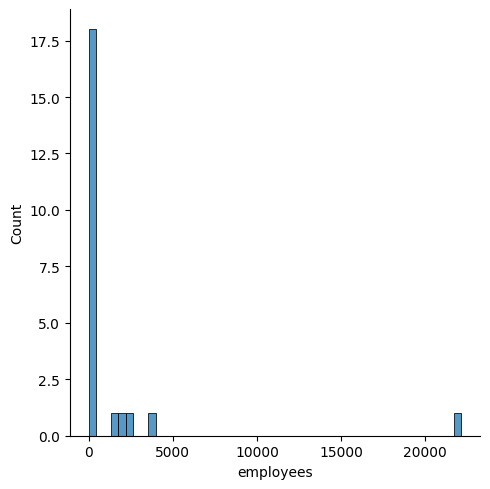

In [56]:
sns.displot(employees, kind='hist', bins=50) # histogram is default kind

Mean is **HEAVILY** skewed because of larger companies like **Novo Nordisk**.

It absolutely does **not** follow normal distribution, but our sample size is tiny, and variance is humongous.

Let's remove outliers and replace missing values with **median**.

(*Since scraping employee data from Proff.dk, we no longer have missing values.*)

In [57]:
lo = employees.quantile(.05)
hi = employees.quantile(.95)
print(lo, hi)
print(employees.quantile([.05,.5,.95])) # other way to get those values. 0.5 included for fun because it's also the median.

3.5000000000000004 3511.7999999999984
0.05       3.5
0.50      83.0
0.95    3511.8
Name: employees, dtype: float64


In [58]:
no_outliers = employees[(employees < hi) & (employees > lo)]
print(no_outliers)
print(no_outliers.describe())
# median is the same

Dynatest A/S                           36.0
Eriksholm Research Centre, Oticon      42.0
Formpipe                               87.0
PFA                                  1464.0
Topdanmark                              8.0
KMD A/S                              1855.0
NorthTech ApS                          20.0
Alpha Solutions                        59.0
Dafolo                                 83.0
Netcompany A/S                       2340.0
Wash World                             72.0
Carve                                  46.0
GroupM                                266.0
Brøndbyernes I.F.                     297.0
PreCure                                15.0
Wilke                                 175.0
OOONO                                  40.0
Elbek & Vejrup                        171.0
Ellab                                 166.0
Name: employees, dtype: float64
count      19.000000
mean      381.157895
std       690.271707
min         8.000000
25%        41.000000
50%        83.000000
75%   

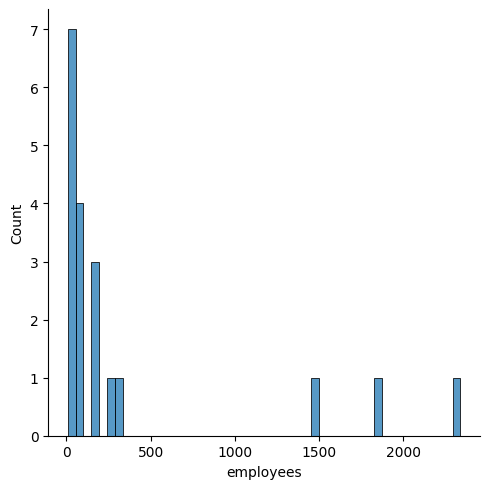

In [59]:
sns.displot(no_outliers, bins=50)

Not much really changed from the previous plot.

In [60]:
df_company.employees.fillna(employees.median(), inplace=True) # median has skipna=True by default
df_company.employees

Dynatest A/S                            36.0
Eriksholm Research Centre, Oticon       42.0
Formpipe                                87.0
Novo Nordisk                         22150.0
PFA                                   1464.0
Topdanmark                               8.0
KMD A/S                               1855.0
NorthTech ApS                           20.0
Alpha Solutions                         59.0
Dafolo                                  83.0
Nuuday A/S                            3642.0
Netcompany A/S                        2340.0
Wash World                              72.0
Carve                                   46.0
GroupM                                 266.0
Brøndbyernes I.F.                      297.0
Meew                                    83.0
Funelo                                  83.0
PreCure                                 15.0
Wilke                                  175.0
OOONO                                   40.0
Elbek & Vejrup                         171.0
Ellab     

## Encoding text data
The only real labels I can see are the *city names*, and *industry types*. Cities are kind of already encoded to numerical with ZIP codes, and the industries already have a code used in the API. But let's one-hot encode it anyway.

In [61]:
ohe = OneHotEncoder(sparse_output=False)

In [62]:
encoded_data = ohe.fit_transform(df_company[['city', 'industrydesc']])
encoded_data

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [63]:
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['city', 'industrydesc'])).set_index(df_company.index)
# the problem was that the encoded df didn't have the same index as the original df
# so the concat would append new rows instead of replacing the old ones
encoded_df.head()

,city_Aarhus N,city_Allinge,city_Bagsværd,city_Ballerup,city_Brøndby,city_Frederikshavn,city_Herlev,city_Hillerød,city_Kongens Lyngby,city_København K,...,industrydesc_Finansielle holdingselskaber,industrydesc_Fremstilling af farmaceutiske præparater,industrydesc_Fremstilling af medicinske og dentale instrumenter samt udstyr hertil,industrydesc_Ikke-finansielle holdingselskaber,industrydesc_Ikke-finansielle hovedsæders virksomhed,industrydesc_Konsulentbistand vedrørende informationsteknologi,industrydesc_Markedsanalyse og offentlig meningsmåling,industrydesc_Sportsklubber,industrydesc_Udgivelse af bøger,industrydesc_Uoplyst
Dynatest A/S,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Eriksholm Research Centre, Oticon",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Formpipe,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Novo Nordisk,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PFA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
df_processed = pd.concat([df_company, encoded_df], axis=1)
df_processed.head()

,vat,name,address,zipcode,city,phone,email,startdate,employees,addressco,...,industrydesc_Finansielle holdingselskaber,industrydesc_Fremstilling af farmaceutiske præparater,industrydesc_Fremstilling af medicinske og dentale instrumenter samt udstyr hertil,industrydesc_Ikke-finansielle holdingselskaber,industrydesc_Ikke-finansielle hovedsæders virksomhed,industrydesc_Konsulentbistand vedrørende informationsteknologi,industrydesc_Markedsanalyse og offentlig meningsmåling,industrydesc_Sportsklubber,industrydesc_Udgivelse af bøger,industrydesc_Uoplyst
Dynatest A/S,20318872,A/S DYNATEST ENGINEERING,Generatorvej 21,2730,Herlev,NaN,None,15/10 - 1981,36.0,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Eriksholm Research Centre, Oticon",50091015,PROPOLIS RESEARCH CENTRE A/S,Lille Veksøvej 11,3670,Veksø Sjælland,NaN,None,10/09 - 1974,42.0,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Formpipe,26366216,FORMPIPE LASERNET A/S,Lautrupvang 1,2750,Ballerup,43660210.0,admin.lasernet@formpipe.com,13/12 - 2001,87.0,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Novo Nordisk,24256790,NOVO NORDISK A/S,Novo Alle 1,2880,Bagsværd,44448888.0,None,28/11 - 1931,22150.0,None,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PFA,31050162,PFA BANK A/S,Sundkrogsgade 4,2100,København Ø,70808500.0,post@pfabank.dk,02/11 - 2007,1464.0,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
df_processed.drop(['city', 'industrydesc'], axis=1, inplace=True)

# Building ML models
We start with linear regression model to predict a company's finances for 2022.

But first let's just have a look at some plots for all the companies' revenue of the years.

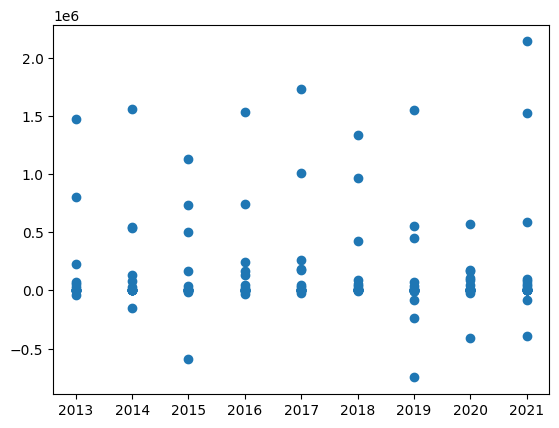

In [66]:
finances = df_processed.loc[:, 2021:2013]
finances.drop('Novo Nordisk', inplace=True) # outlier
X = finances.columns.astype(int)
y = [finances.loc[i] for i in finances.index]
plt.scatter([X]*len(finances), y)

The only trend is that time moves forward.

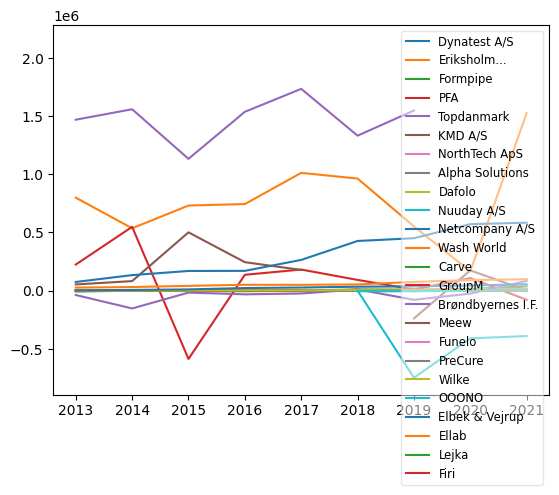

In [67]:
for i in finances.index:
    plt.plot(X, finances.loc[i], label=shorten(i, width=20, placeholder='...'))
plt.legend(loc='upper right', fontsize='small', fancybox=True, framealpha=0.5)
plt.show()

Because companies vary wildly in their finances, both in terms of the company's size and also their structure and strategy within a larger organization, we will build a model for the individual company.

What I mean by different finance strategy is that some companies report 0 net profits presumably because they send the money to a parent company. Other companies have 0 gross because their purpose is not to make money. As a result, some companies seemingly report wild losses as the end result.

I don't know finances at all. But that's a lot of companies making close to 0 or negative money.

Now let's try building a linear regression model.

In [68]:
def build_projected_profit_model(company):
    finances = df_processed.loc[company, 2021:2013]         # get the finances for the company
    X = finances.index.to_numpy().reshape(-1, 1)    # Xs are the year labels
    y = finances
    model = LinearRegression().fit(X, y)
    plt.plot(X, y, label=company)
    plt.plot(X, model.predict(X), label=f'{company} projected')
    plt.legend()
    plt.show()
    return model

Let's use **Novo Nordisk** as an example because they seem to have stable finances that don't look weird. Their financial data also goes back all the way to 2013. That is the case with all but 2 companies so far.

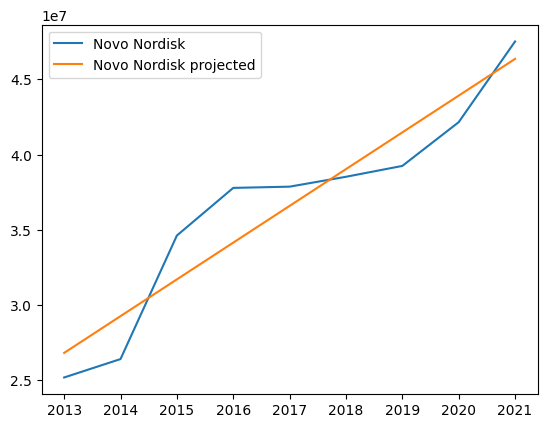

In [69]:
novo_model = build_projected_profit_model('Novo Nordisk')

And now, let's predict a profit for **2022**.

In [70]:
novo_2022 = novo_model.predict(np.array([2022]).reshape(-1, 1))
novo_2022[0]

48808805.55555534

I don't think we can assess the accuracy at all because we did not split training data. We chose not to because we already have insanely little data to train on. As a result, we have no test data with which to assess the accuracy of the model.

## NLP
We'll be getting articles from Wikipedia, and parsing them with spaCy/DaCy.

In [71]:
import wikipedia
import wikipediaapi

In [72]:
# wiki_wiki = wikipediaapi.Wikipedia('da')

In [73]:
wikipedia.set_lang('da')

In [74]:
# pages = {}
# for i in df_company.index:
#     try:
#         page = wikipedia.page(i)
#         print(i, page.url)
#         pages[i] = page
#     except wikipedia.exceptions.DisambiguationError as e:
#         print(i, e.options)
#     except wikipedia.exceptions.PageError as e:
#         print(i, e)

In [75]:
pages = json_or_fetch(df_company.index, fetch.wikipedia, 'data/wikipedia_pages.json')

In [76]:
import dacy
import nltk
from string import punctuation

In [77]:
for model in dacy.models():
    print(model)

da_dacy_small_tft-0.0.0
da_dacy_medium_tft-0.0.0
da_dacy_large_tft-0.0.0
da_dacy_small_trf-0.1.0
da_dacy_medium_trf-0.1.0
da_dacy_large_trf-0.1.0
da_dacy_small_trf-latest
da_dacy_medium_trf-latest
da_dacy_large_trf-latest


In [78]:
nlp = dacy.load('da_dacy_medium_trf-latest') # or specific version (0.1.0) or just 'medium'

c:\Python39\lib\site-packages\spacy\util.py:887: UserWarning: [W095] Model 'da_dacy_medium_trf' (0.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.5.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
c:\Python39\lib\site-packages\spacy_transformers\pipeline_component.py:402: UserWarning: Automatically converting a transformer component from spacy-transformers v1.0 to v1.1+. If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spacy-transformers version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [79]:
# nltk.download('stopwords')
da_stopwords = nltk.corpus.stopwords.words('danish')

Just a test to show filtering out stopwords and punctuation.

In [80]:
text = "Det her er noget tekst til at teste, hvad Dacy kan. Jeg håber, at den kan finde ord som 'test' og 'håber'."
doc = nlp(text)
for token in doc:
    # easier than "token is not in da_stopwords and token not in punctuation"
    # also means you don't have to lowercase the tokens
    if not token.is_stop and not token.is_punct:
        print(token.lemma_, token.pos_)

tekst NOUN
teste VERB
Dacy PROPN
håbe VERB
finde VERB
ord NOUN
test NOUN
håbe NOUN


c:\Python39\lib\site-packages\spacy\pipeline\attributeruler.py:150: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [81]:
from wordcloud import WordCloud

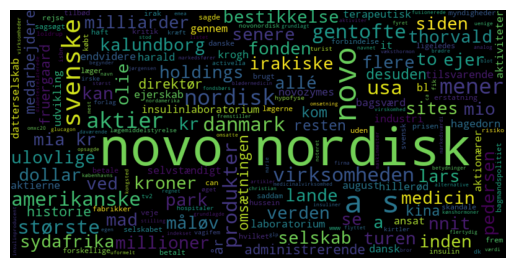

In [82]:
wordcloud = WordCloud(width=800, height=400, stopwords=da_stopwords).generate(pages['Novo Nordisk'].lower())
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

I'm sorry, but I don't know what kind of application or prototype would be suitable for this data. Maybe a summarisation thing like shown in class, finding the sentences closest to a centroid. I didn't have a lot of time to really explore and come up with an application, so all I did was a word cloud.

## TrustPilot reviews

In [2]:
url = 'https://dk.trustpilot.com/review/www.netcompany.com'

In [5]:
reviews = json_or_fetch(url, fetch.trustpilot, 'data/trustpilot.json')